# Neural Network Models

First we need to load all the packages necessary for this notebook. In order to install the packages run pip install requirements.txt

In [23]:
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import os
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

Next we get the data using the environment variable ```RESEARCH_DATA_PATH``` which should direct to the data folder of this project

In [24]:
DATA_PATH = os.environ.get("RESEARCH_DATA_PATH")

In [25]:
#MONTHLY DATA
X_mef_m = pd.read_csv(f'{DATA_PATH}/processed/mef_monthly_data_processed.csv')
X_mai_m = pd.read_csv(f'{DATA_PATH}/processed/mai_monthly_data_processed.csv')
y_mkt_m = pd.read_csv(f'{DATA_PATH}/processed/mkt_monthly_data_processed.csv')

X_mef_m['date'] = pd.to_datetime(X_mef_m['date'])
X_mai_m['date'] = pd.to_datetime(X_mai_m['date'])
y_mkt_m['date'] = pd.to_datetime(y_mkt_m['date'])

# Drop the 'date' column from each dataset
X_mef_m = X_mef_m.drop('date', axis=1)
X_mai_m = X_mai_m.drop('date', axis=1)
y_mkt_m = y_mkt_m.drop('date', axis=1)

X_mef_m = X_mef_m.values
X_mai_m = X_mai_m.values
y_mkt_m = y_mkt_m.values

#DAILY DATA
X_mef_d = pd.read_csv(f'{DATA_PATH}/processed/mef_daily_data_processed.csv')
X_mai_d = pd.read_csv(f'{DATA_PATH}/processed/mai_daily_data_processed.csv')
y_mkt_d = pd.read_csv(f'{DATA_PATH}/processed/mkt_daily_data_processed.csv')

X_mef_d['date'] = pd.to_datetime(X_mef_d['date'])
X_mai_d['date'] = pd.to_datetime(X_mai_d['date'])
y_mkt_d['date'] = pd.to_datetime(y_mkt_d['date'])

# Drop the 'date' column from each dataset
X_mef_d = X_mef_d.drop('date', axis=1)
X_mai_d = X_mai_d.drop('date', axis=1)
y_mkt_d = y_mkt_d.drop('date', axis=1)

X_mef_d = X_mef_d.values
X_mai_d = X_mai_d.values
y_mkt_d = y_mkt_d.values

In [26]:
# Function: split data into training and test set based on the random state
def split_data(X, y, test_size, random_state):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=test_size,random_state=random_state)
    return X_train, y_train, X_test, y_test

In [27]:
# Function: build the neural network model

def train_neural_network(X, y):
    """
    Parameters:
    - X: MAI features
    - y: Target variable

    Returns:
    - Trained model
    - Model training history
    """

    # the best number of layers, dropout layers, the best number of units of a layer have been selected
    model = keras.Sequential([
    layers.Dense(64, activation=keras.layers.ELU(),input_dim=8),
    Dropout(0.3),
    layers.Dense(32, activation=keras.layers.ELU()),
    Dropout(0.5),
    layers.Dense(1)  # Output layer with 1 neuron for numerical output
    ])

    # Compile the model
    # the best optimizer and learning rate have been selected
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])

    # Train the model
    # the best number of epochs and batch_size have been selected
    history = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2)

    # Plot training and validation accuracy over epochs
    plt.plot(history.history['loss'], label='Training MSE')
    plt.plot(history.history['val_loss'], label='Validation MSE')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return model, history

In [28]:
#Function: evaluate the performance of the model and show the values in plot
def test_model(model, X_test, y_test):
    """
    Test a trained model and calculate regression metrics.

    Parameters:
    - model: Trained model
    - X_test: Testing features
    - y_test: True values for testing

    Returns:
    - Mean Squared Error (MSE)
    - Mean Absolute Error (MAE)
    - R-squared (R2) score
    """

    # Make y_pred using the trained model
    y_pred = model.predict(X_test)

    # Calculate regression metrics
    MSE = mean_squared_error(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    R2 = r2_score(y_test, y_pred)

    # Plot predicted values and true values

    new_y_test = [value for index, value in enumerate(y_test)]
    plt.plot(new_y_test, label='True',color='blue')
    plt.plot(y_pred, label='Prediction',color='red')

    plt.xlabel('Index')
    plt.ylabel('y values')
    plt.title('True vs Pred')

    plt.legend()

    plt.show()

    return MSE, MAE, R2

Epoch 1/20
9/9 [==============================] - 1s 25ms/step - loss: 2643.9614 - mae: 39.6422 - val_loss: 3589.9236 - val_mae: 41.3637
Epoch 2/20
9/9 [==============================] - 0s 8ms/step - loss: 2654.1946 - mae: 39.7220 - val_loss: 3590.2715 - val_mae: 41.3603
Epoch 3/20
9/9 [==============================] - 0s 7ms/step - loss: 2663.1470 - mae: 39.7599 - val_loss: 3590.5598 - val_mae: 41.3571
Epoch 4/20
9/9 [==============================] - 0s 7ms/step - loss: 2648.2241 - mae: 39.6765 - val_loss: 3590.9985 - val_mae: 41.3538
Epoch 5/20
9/9 [==============================] - 0s 7ms/step - loss: 2654.9714 - mae: 39.6202 - val_loss: 3591.4458 - val_mae: 41.3500
Epoch 6/20
9/9 [==============================] - 0s 7ms/step - loss: 2652.8179 - mae: 39.5148 - val_loss: 3591.9631 - val_mae: 41.3483
Epoch 7/20
9/9 [==============================] - 0s 9ms/step - loss: 2673.8945 - mae: 39.7996 - val_loss: 3592.4629 - val_mae: 41.3468
Epoch 8/20
9/9 [==============================]

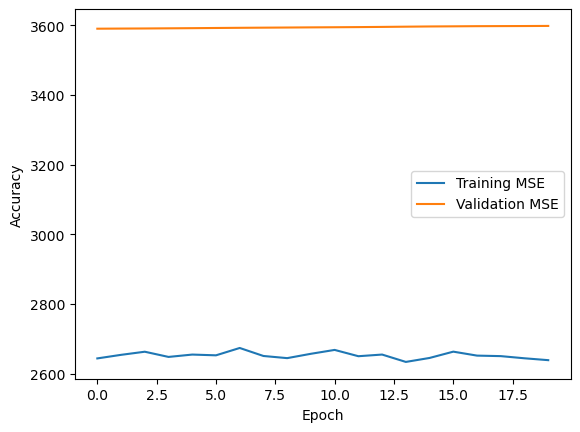

3/3 [==============================] - 0s 9ms/step


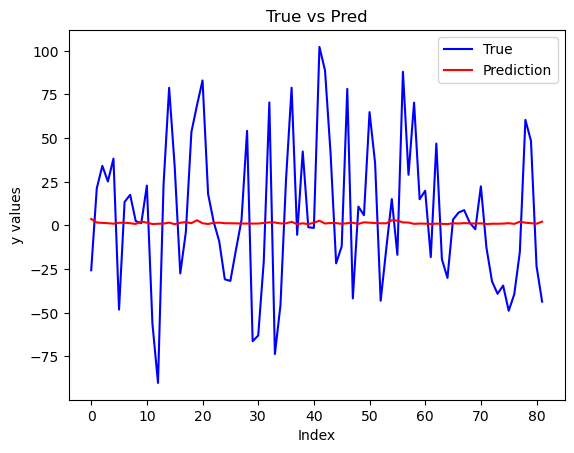

RMSE: 42.40374254215058, MAE: 33.97191396177683, R2: -0.012068569413955066


In [29]:
# Train a model on MAI monthly data
# Generate training and test data sets
X_train, y_train, X_test, y_test = split_data(X_mai_m, y_mkt_m, 0.2, 0)

# Use X_train and y_train as MAI features and target variable
trained_model, training_history = train_neural_network(X_train, y_train)

# Have the performance of the trained model evaluated on the test set
MSE, MAE, R2 = test_model(trained_model, X_test, y_test)
print(f'RMSE: {MSE**(1/2)}, MAE: {MAE}, R2: {R2}')

Epoch 1/20
9/9 [==============================] - 1s 24ms/step - loss: 2642.6013 - mae: 39.4899 - val_loss: 3612.1689 - val_mae: 41.4543
Epoch 2/20
9/9 [==============================] - 0s 8ms/step - loss: 2654.6431 - mae: 39.5513 - val_loss: 3612.7148 - val_mae: 41.4571
Epoch 3/20
9/9 [==============================] - 0s 7ms/step - loss: 2651.0798 - mae: 39.5401 - val_loss: 3613.0996 - val_mae: 41.4591
Epoch 4/20
9/9 [==============================] - 0s 7ms/step - loss: 2664.7593 - mae: 39.6850 - val_loss: 3613.4431 - val_mae: 41.4610
Epoch 5/20
9/9 [==============================] - 0s 7ms/step - loss: 2639.4858 - mae: 39.3456 - val_loss: 3613.8413 - val_mae: 41.4629
Epoch 6/20
9/9 [==============================] - 0s 7ms/step - loss: 2639.0417 - mae: 39.4039 - val_loss: 3614.2034 - val_mae: 41.4645
Epoch 7/20
9/9 [==============================] - 0s 8ms/step - loss: 2668.3979 - mae: 39.5061 - val_loss: 3614.3682 - val_mae: 41.4651
Epoch 8/20
9/9 [==============================]

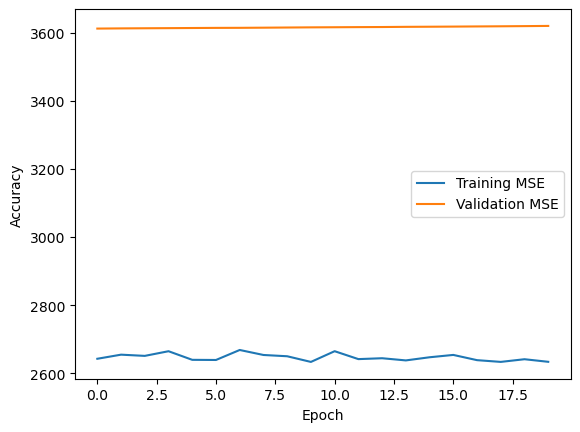

3/3 [==============================] - 0s 2ms/step


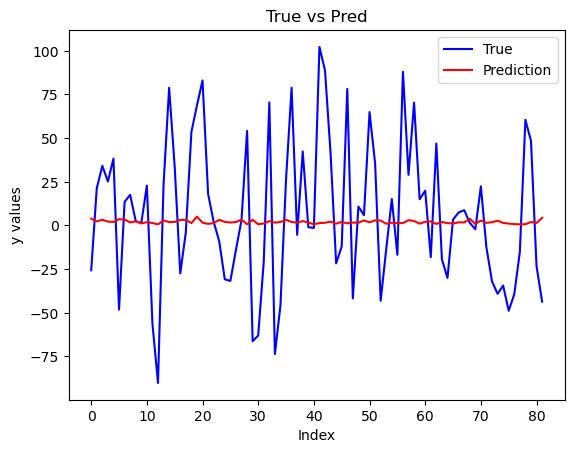

MSE: 1798.593734379909, MAE: 33.90036237556154, R2: -0.012359204535594914
Epoch 1/20
9/9 [==============================] - 1s 20ms/step - loss: 2828.0342 - mae: 39.2342 - val_loss: 1805.9121 - val_mae: 34.7285
Epoch 2/20
9/9 [==============================] - 0s 6ms/step - loss: 2824.2395 - mae: 39.1039 - val_loss: 1805.2375 - val_mae: 34.7186
Epoch 3/20
9/9 [==============================] - 0s 6ms/step - loss: 2818.9634 - mae: 39.1240 - val_loss: 1804.6278 - val_mae: 34.7090
Epoch 4/20
9/9 [==============================] - 0s 6ms/step - loss: 2807.5632 - mae: 39.0938 - val_loss: 1804.1588 - val_mae: 34.7011
Epoch 5/20
9/9 [==============================] - 0s 6ms/step - loss: 2800.2527 - mae: 38.9693 - val_loss: 1803.5669 - val_mae: 34.6912
Epoch 6/20
9/9 [==============================] - 0s 6ms/step - loss: 2813.4424 - mae: 39.1125 - val_loss: 1803.0074 - val_mae: 34.6815
Epoch 7/20
9/9 [==============================] - 0s 6ms/step - loss: 2798.6721 - mae: 38.8200 - val_loss: 18

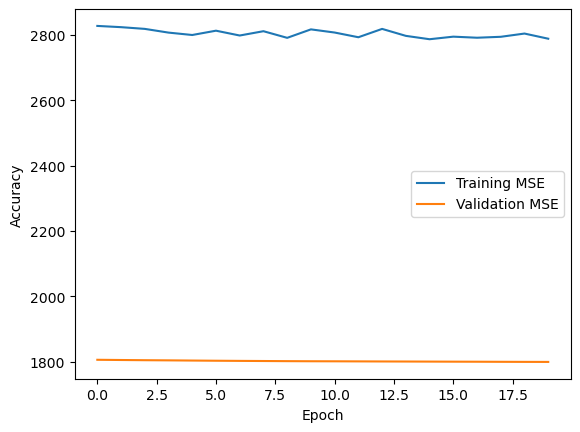

3/3 [==============================] - 0s 7ms/step


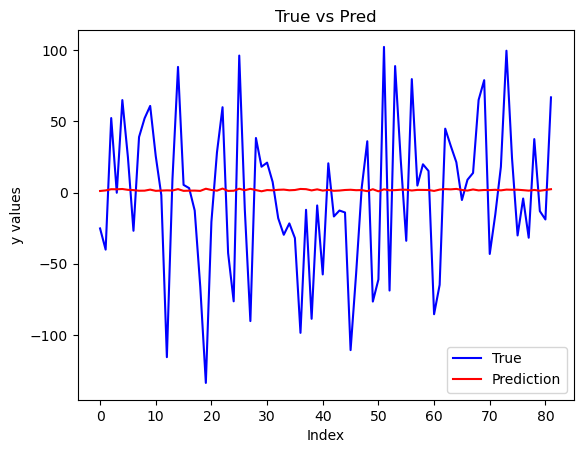

MSE: 2749.034637447099, MAE: 41.38432355762606, R2: -0.00359560865013564
Epoch 1/20
9/9 [==============================] - 1s 22ms/step - loss: 2202.4377 - mae: 35.1797 - val_loss: 2810.9866 - val_mae: 40.1483
Epoch 2/20
9/9 [==============================] - 0s 7ms/step - loss: 2219.9673 - mae: 35.3452 - val_loss: 2811.4587 - val_mae: 40.1187
Epoch 3/20
9/9 [==============================] - 0s 6ms/step - loss: 2193.0752 - mae: 35.2039 - val_loss: 2811.7810 - val_mae: 40.1055
Epoch 4/20
9/9 [==============================] - 0s 6ms/step - loss: 2201.2407 - mae: 35.3174 - val_loss: 2812.1379 - val_mae: 40.0900
Epoch 5/20
9/9 [==============================] - 0s 7ms/step - loss: 2183.9963 - mae: 35.1811 - val_loss: 2812.6709 - val_mae: 40.0655
Epoch 6/20
9/9 [==============================] - 0s 6ms/step - loss: 2205.8152 - mae: 35.3520 - val_loss: 2813.2361 - val_mae: 40.0413
Epoch 7/20
9/9 [==============================] - 0s 6ms/step - loss: 2192.2036 - mae: 35.1970 - val_loss: 281

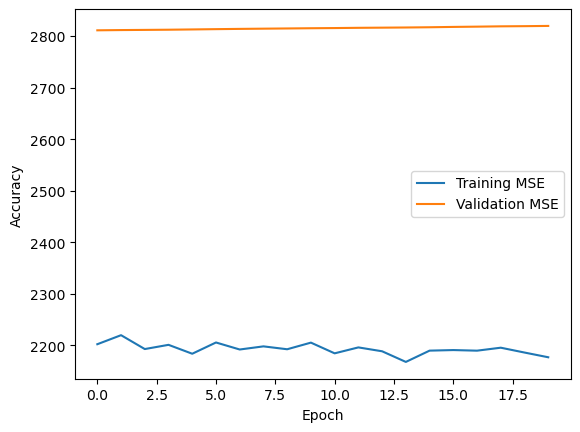

3/3 [==============================] - 0s 4ms/step


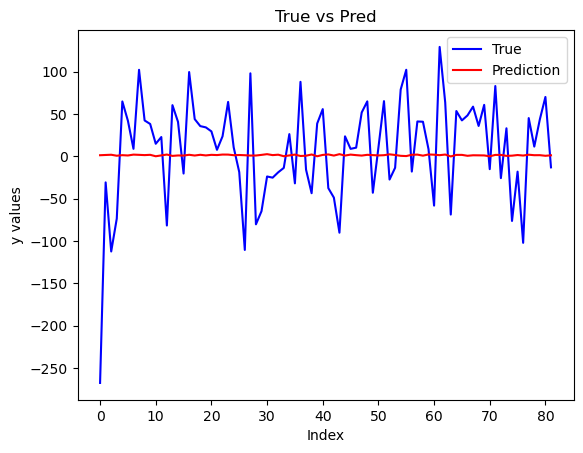

MSE: 3898.052576113464, MAE: 49.39883265093725, R2: -0.015374995209023412
Epoch 1/20
9/9 [==============================] - 1s 20ms/step - loss: 2863.9595 - mae: 39.6416 - val_loss: 2314.8503 - val_mae: 38.4891
Epoch 2/20
9/9 [==============================] - 0s 6ms/step - loss: 2851.7539 - mae: 39.4108 - val_loss: 2313.1221 - val_mae: 38.4576
Epoch 3/20
9/9 [==============================] - 0s 6ms/step - loss: 2852.4661 - mae: 39.4708 - val_loss: 2312.1963 - val_mae: 38.4407
Epoch 4/20
9/9 [==============================] - 0s 8ms/step - loss: 2862.6729 - mae: 39.4538 - val_loss: 2310.8059 - val_mae: 38.4149
Epoch 5/20
9/9 [==============================] - 0s 6ms/step - loss: 2846.3081 - mae: 39.3574 - val_loss: 2309.1731 - val_mae: 38.3850
Epoch 6/20
9/9 [==============================] - 0s 6ms/step - loss: 2854.5256 - mae: 39.4560 - val_loss: 2307.8989 - val_mae: 38.3614
Epoch 7/20
9/9 [==============================] - 0s 6ms/step - loss: 2847.7639 - mae: 39.3545 - val_loss: 23

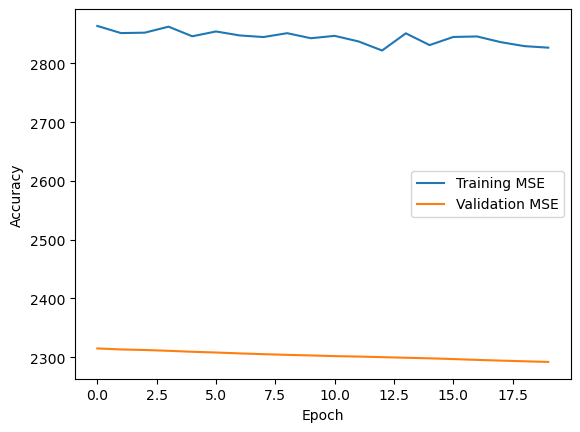

3/3 [==============================] - 0s 0s/step


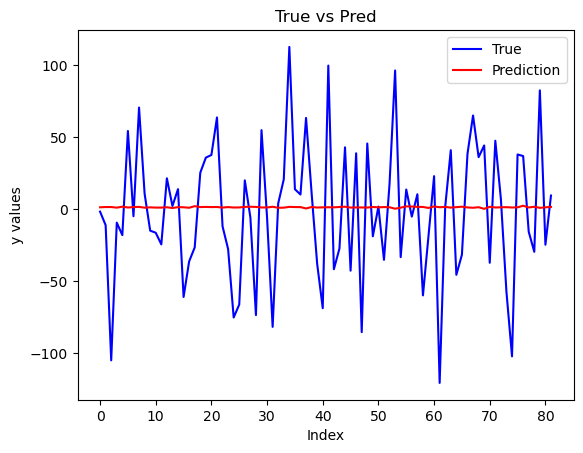

MSE: 2276.2291513080136, MAE: 37.82870139706005, R2: -0.005986085965111743
Epoch 1/20
9/9 [==============================] - 1s 19ms/step - loss: 2891.6152 - mae: 40.5983 - val_loss: 2405.7510 - val_mae: 37.6816
Epoch 2/20
9/9 [==============================] - 0s 7ms/step - loss: 2905.9917 - mae: 40.7143 - val_loss: 2405.0127 - val_mae: 37.6711
Epoch 3/20
9/9 [==============================] - 0s 7ms/step - loss: 2893.4116 - mae: 40.6751 - val_loss: 2404.2378 - val_mae: 37.6599
Epoch 4/20
9/9 [==============================] - 0s 6ms/step - loss: 2886.3303 - mae: 40.6436 - val_loss: 2403.3770 - val_mae: 37.6475
Epoch 5/20
9/9 [==============================] - 0s 6ms/step - loss: 2880.8035 - mae: 40.4967 - val_loss: 2402.7954 - val_mae: 37.6393
Epoch 6/20
9/9 [==============================] - 0s 6ms/step - loss: 2897.3025 - mae: 40.5498 - val_loss: 2401.9102 - val_mae: 37.6265
Epoch 7/20
9/9 [==============================] - 0s 6ms/step - loss: 2897.8442 - mae: 40.6554 - val_loss: 2

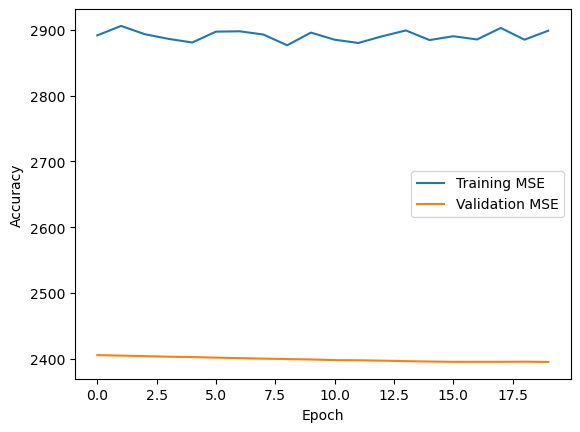

3/3 [==============================] - 0s 5ms/step


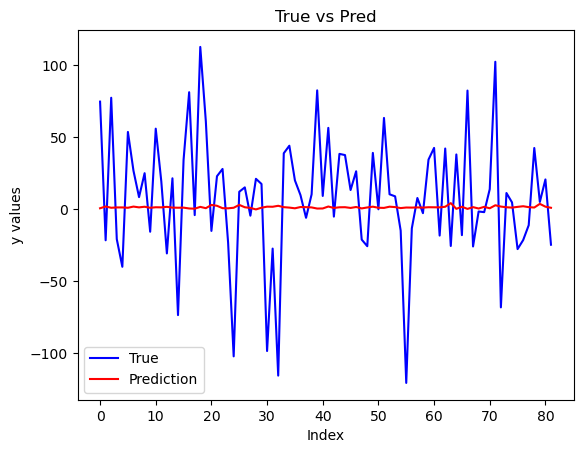

MSE: 2001.1864743000872, MAE: 33.607557676961115, R2: -0.030252641700782013
Epoch 1/20
9/9 [==============================] - 1s 25ms/step - loss: 2778.5181 - mae: 38.8624 - val_loss: 1759.6564 - val_mae: 32.2597
Epoch 2/20
9/9 [==============================] - 0s 7ms/step - loss: 2766.4641 - mae: 38.8102 - val_loss: 1758.9590 - val_mae: 32.2305
Epoch 3/20
9/9 [==============================] - 0s 7ms/step - loss: 2781.8679 - mae: 38.9398 - val_loss: 1758.7019 - val_mae: 32.2196
Epoch 4/20
9/9 [==============================] - 0s 7ms/step - loss: 2778.2698 - mae: 38.7192 - val_loss: 1758.4490 - val_mae: 32.2048
Epoch 5/20
9/9 [==============================] - 0s 7ms/step - loss: 2774.0095 - mae: 38.7979 - val_loss: 1758.0701 - val_mae: 32.1866
Epoch 6/20
9/9 [==============================] - 0s 8ms/step - loss: 2773.2542 - mae: 38.7628 - val_loss: 1758.0031 - val_mae: 32.1826
Epoch 7/20
9/9 [==============================] - 0s 7ms/step - loss: 2779.2107 - mae: 38.7886 - val_loss: 

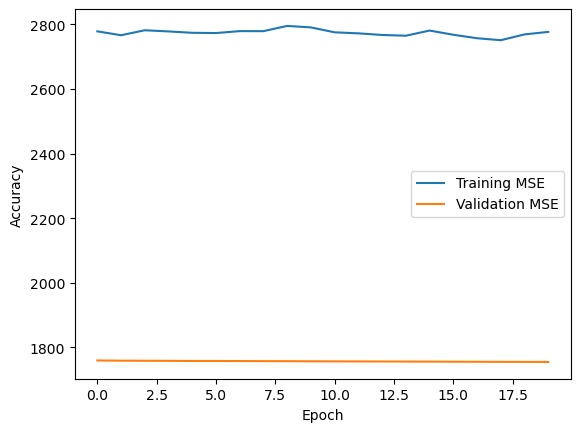

3/3 [==============================] - 0s 10ms/step


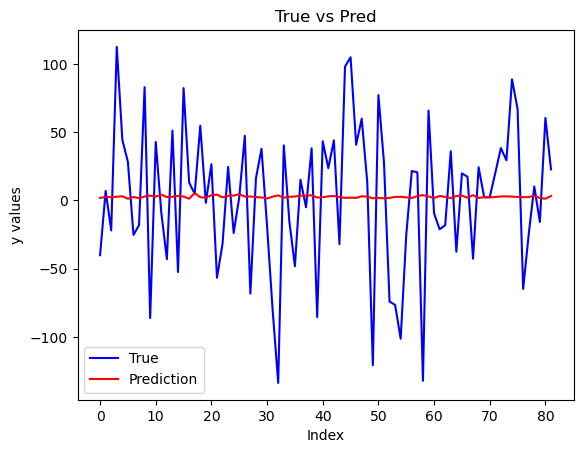

MSE: 2853.932554257994, MAE: 42.565747034121756, R2: -0.004536434373161979
Epoch 1/20
9/9 [==============================] - 1s 31ms/step - loss: 2279.6914 - mae: 36.7498 - val_loss: 2826.3806 - val_mae: 40.0206
Epoch 2/20
9/9 [==============================] - 0s 10ms/step - loss: 2284.8459 - mae: 36.8129 - val_loss: 2825.5652 - val_mae: 39.9972
Epoch 3/20
9/9 [==============================] - 0s 8ms/step - loss: 2281.7905 - mae: 36.7849 - val_loss: 2825.0134 - val_mae: 39.9811
Epoch 4/20
9/9 [==============================] - 0s 7ms/step - loss: 2273.1716 - mae: 36.7542 - val_loss: 2824.6362 - val_mae: 39.9695
Epoch 5/20
9/9 [==============================] - 0s 8ms/step - loss: 2272.1423 - mae: 36.7033 - val_loss: 2824.0701 - val_mae: 39.9560
Epoch 6/20
9/9 [==============================] - 0s 7ms/step - loss: 2272.4197 - mae: 36.6864 - val_loss: 2823.5503 - val_mae: 39.9423
Epoch 7/20
9/9 [==============================] - 0s 7ms/step - loss: 2277.0742 - mae: 36.7757 - val_loss: 

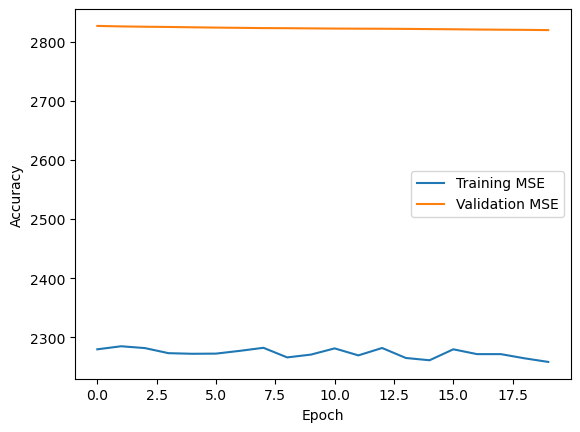

3/3 [==============================] - 0s 4ms/step


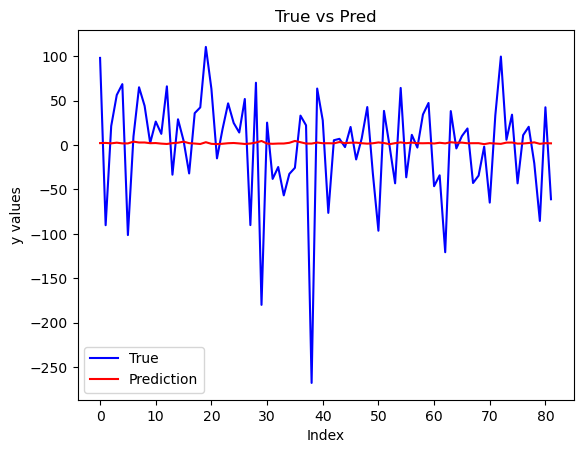

MSE: 3592.3641417293543, MAE: 43.46061404483514, R2: -0.003978580606094795
Epoch 1/20
9/9 [==============================] - 1s 26ms/step - loss: 2316.0234 - mae: 36.3927 - val_loss: 3261.7971 - val_mae: 44.8370
Epoch 2/20
9/9 [==============================] - 0s 8ms/step - loss: 2313.2761 - mae: 36.3346 - val_loss: 3261.2161 - val_mae: 44.8213
Epoch 3/20
9/9 [==============================] - 0s 7ms/step - loss: 2320.9412 - mae: 36.3850 - val_loss: 3260.7900 - val_mae: 44.8095
Epoch 4/20
9/9 [==============================] - 0s 7ms/step - loss: 2314.3406 - mae: 36.3717 - val_loss: 3260.4519 - val_mae: 44.8012
Epoch 5/20
9/9 [==============================] - 0s 8ms/step - loss: 2319.2222 - mae: 36.3146 - val_loss: 3259.8958 - val_mae: 44.7863
Epoch 6/20
9/9 [==============================] - 0s 6ms/step - loss: 2308.6462 - mae: 36.3038 - val_loss: 3259.3142 - val_mae: 44.7701
Epoch 7/20
9/9 [==============================] - 0s 6ms/step - loss: 2332.7952 - mae: 36.4553 - val_loss: 3

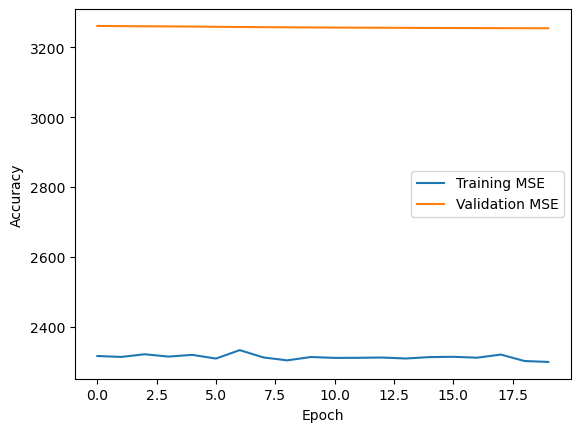

3/3 [==============================] - 0s 5ms/step


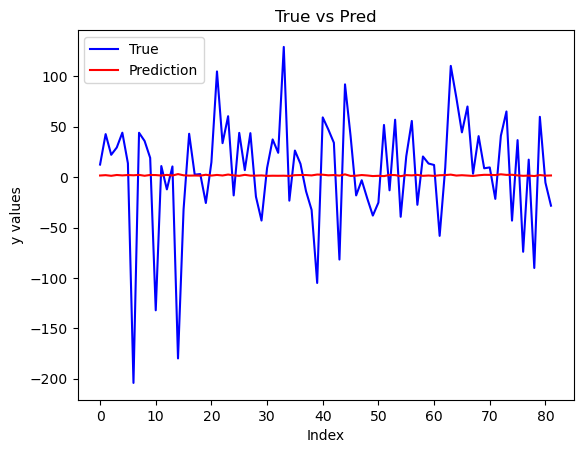

MSE: 3117.9484402978746, MAE: 41.08339437969843, R2: -0.007999615947549277
Epoch 1/20
9/9 [==============================] - 1s 23ms/step - loss: 2785.4441 - mae: 39.1238 - val_loss: 2141.9636 - val_mae: 35.4591
Epoch 2/20
9/9 [==============================] - 0s 6ms/step - loss: 2779.4717 - mae: 39.1495 - val_loss: 2142.3530 - val_mae: 35.4666
Epoch 3/20
9/9 [==============================] - 0s 7ms/step - loss: 2767.3428 - mae: 39.0192 - val_loss: 2142.3672 - val_mae: 35.4665
Epoch 4/20
9/9 [==============================] - 0s 8ms/step - loss: 2762.9209 - mae: 39.0318 - val_loss: 2142.2886 - val_mae: 35.4653
Epoch 5/20
9/9 [==============================] - 0s 8ms/step - loss: 2743.8516 - mae: 38.9196 - val_loss: 2141.8784 - val_mae: 35.4573
Epoch 6/20
9/9 [==============================] - 0s 7ms/step - loss: 2771.3137 - mae: 39.0502 - val_loss: 2141.4629 - val_mae: 35.4484
Epoch 7/20
9/9 [==============================] - 0s 8ms/step - loss: 2766.8677 - mae: 39.0084 - val_loss: 2

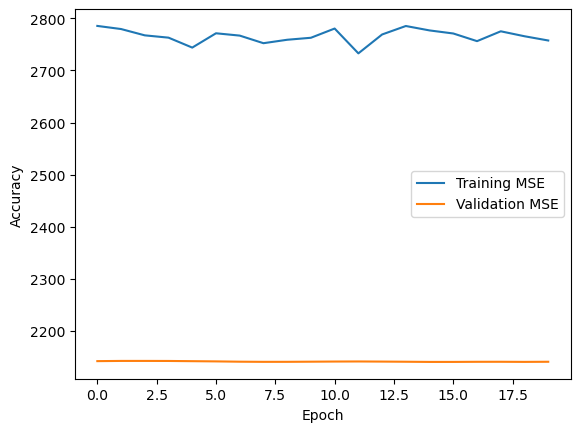

3/3 [==============================] - 0s 8ms/step


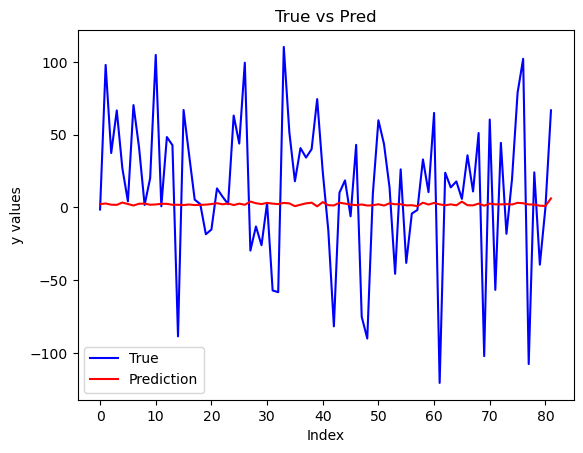

MSE: 2564.784801950999, MAE: 39.30879783195541, R2: -0.04180485547886548
Epoch 1/20
9/9 [==============================] - 1s 22ms/step - loss: 2645.6809 - mae: 39.6142 - val_loss: 2103.2898 - val_mae: 37.8931
Epoch 2/20
9/9 [==============================] - 0s 6ms/step - loss: 2635.2139 - mae: 39.5255 - val_loss: 2103.0039 - val_mae: 37.8906
Epoch 3/20
9/9 [==============================] - 0s 7ms/step - loss: 2630.9568 - mae: 39.5472 - val_loss: 2102.3838 - val_mae: 37.8835
Epoch 4/20
9/9 [==============================] - 0s 8ms/step - loss: 2648.3645 - mae: 39.6047 - val_loss: 2101.5801 - val_mae: 37.8740
Epoch 5/20
9/9 [==============================] - 0s 7ms/step - loss: 2626.3540 - mae: 39.5159 - val_loss: 2101.1025 - val_mae: 37.8686
Epoch 6/20
9/9 [==============================] - 0s 6ms/step - loss: 2631.9888 - mae: 39.5904 - val_loss: 2100.6082 - val_mae: 37.8627
Epoch 7/20
9/9 [==============================] - 0s 7ms/step - loss: 2620.6401 - mae: 39.4006 - val_loss: 210

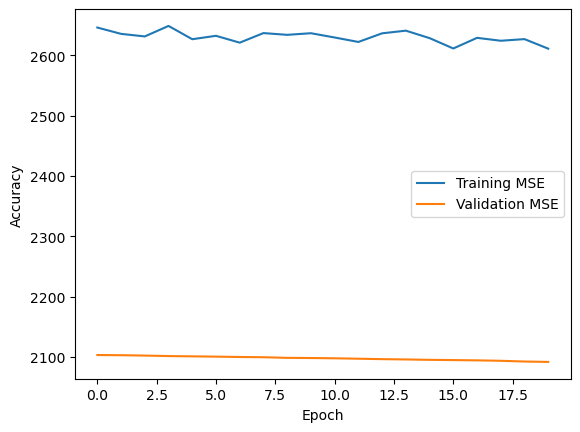

3/3 [==============================] - 0s 8ms/step


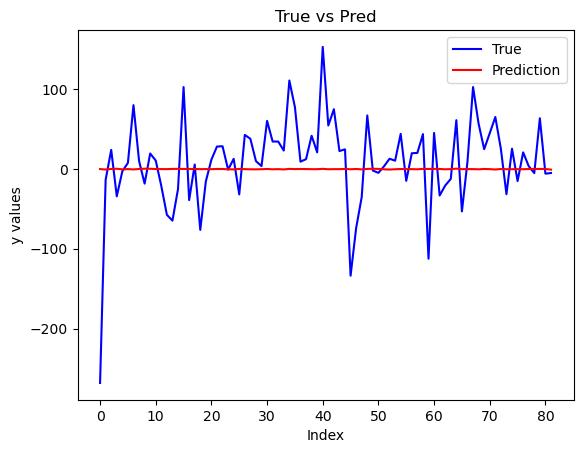

MSE: 3154.2351820270615, MAE: 38.83975269342913, R2: -0.026304405596083935
The average RMSE is 52.572333985981345


In [30]:
# Test the performance of the model on 10 different random train-test splits of MAI monthly data, and report the average RMSE.
list_RMSE=[]
for i in range(0,10):
  # Generate training and test data sets
  X_train, y_train, X_test, y_test = split_data(X_mai_m, y_mkt_m, 0.2, i)

  # Use X_train and y_train as MAI features and target variable
  trained_model, training_history = train_neural_network(X_train, y_train)

  # Have the performance of the trained model evaluated on the test set
  MSE, MAE, R2 = test_model(trained_model, X_test, y_test)
  print(f'MSE: {MSE}, MAE: {MAE}, R2: {R2}')
  list_RMSE.append(MSE**(1/2))
avg_RMSE=np.mean(list_RMSE)
print('The average RMSE is', avg_RMSE)

The standard variation of RMSE is 6.0651355011752575


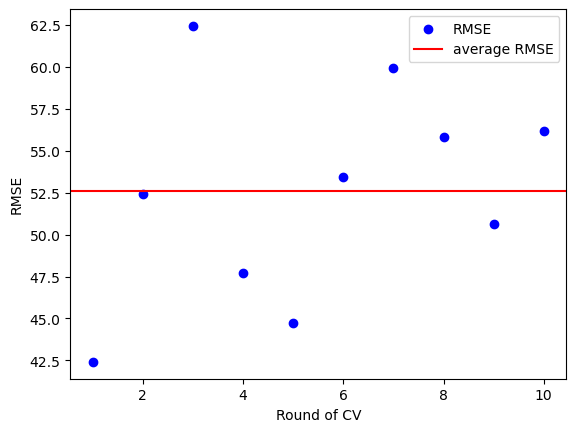

In [31]:
# Calculate the standard variation of RMSE
print('The standard variation of RMSE is', np.std(list_RMSE))
# Plot the RMSE of each round of random split
plt.scatter(y=list_RMSE,x=range(1,11),label='RMSE',color='blue')
plt.axhline(y=avg_RMSE, label='average RMSE',linestyle='-',color='red')

plt.xlabel('Round of CV')
plt.ylabel('RMSE')
#plt.title('RMSE of each round of random split, NN on MAI monthly')

plt.legend()

plt.show()

In [32]:
# Test the performance of the model on 10 different random train-test splits of MEF monthly data, and report the average RMSE.
list_RMSE1=[]
for i in range(0,10):
  # Generate training and test data sets
  X_train, y_train, X_test, y_test = split_data(X_mef_m, y_mkt_m, 0.2, i)

  # Use X_train and y_train as MAI features and target variable
  trained_model, training_history = train_neural_network(X_train, y_train)

  # Have the performance of the trained model evaluated on the test set
  MSE, MAE, R2 = test_model(trained_model, X_test, y_test)
  print(f'MSE: {MSE}, MAE: {MAE}, R2: {R2}')
  list_RMSE1.append(MSE**(1/2))
avg_RMSE1=np.mean(list_RMSE1)
print('The average RMSE is', avg_RMSE1)

Epoch 1/20


ValueError: in user code:

    File "C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_45" is incompatible with the layer: expected shape=(None, 8), found shape=(None, 14)


In [ ]:
# Test the performance of the model on 10 different random train-test splits of MAI daily data, and report the average RMSE.
list_RMSE2=[]
for i in range(0,10):
  # Generate training and test data sets
  X_train, y_train, X_test, y_test = split_data(X_mai_d, y_mkt_d, 0.2, i)

  # Use X_train and y_train as MAI features and target variable
  trained_model, training_history = train_neural_network(X_train, y_train)

  # Have the performance of the trained model evaluated on the test set
  MSE, MAE, R2 = test_model(trained_model, X_test, y_test)
  print(f'MSE: {MSE}, MAE: {MAE}, R2: {R2}')
  list_RMSE2.append(MSE**(1/2))
avg_RMSE2=np.mean(list_RMSE2)
print('The average RMSE is', avg_RMSE2)